# Psychopathy Dataset(s) Exploration

## Dataset 1

In [24]:
# Importing packages
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, \
                             AdaBoostRegressor, GradientBoostingRegressor, \
                             VotingRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LogisticRegression

In [2]:
# Dataset
dark_triad_df = pd.read_csv('Data/archive (6)/data.csv', delimiter = '\t')

In [3]:
# Dropping source column
dark_triad_df.drop(columns = ['source', 'country'], inplace = True)

In [4]:
# CHECKING TABLE SIZES
dark_triad_df.shape    # should be 18192 rows and 29 columns

(18192, 27)

In [5]:
# Looking at the first 3 rows of the dataframe
dark_triad_df.head(3)

,M1,M2,M3,M4,M5,M6,M7,M8,M9,N1,...,N9,P1,P2,P3,P4,P5,P6,P7,P8,P9
0,4,4,4,4,4,4,4,3,4,2,...,4,3,4,3,2,4,4,4,4,4
1,2,1,5,2,2,1,2,2,3,1,...,2,1,1,1,5,4,1,5,3,2
2,3,3,3,5,1,1,5,5,3,2,...,5,3,5,3,1,3,1,2,3,1


All columns except for country and source are scored from 1 to 5, with 1 indicating disagree and 5 indicating agree.

### What is the dark triad?

The dark triad is a collection of three psychological states/conditions: **psychopathy**, **narcissism**, and 
**machiavellianism**. 

In [6]:
# Column averages (mean score for each question)
question_scores = pd.DataFrame(dark_triad_df.mean(axis = 0), columns= ['Scores']). \
                               sort_values(by = 'Scores', ascending = False). \
                               reset_index()

# Dropping the last row (it's about the source of the data)
question_scores = question_scores.iloc[:27, :]  

In [7]:
# Creating a list of to which of the triad members each question belongs
triad_class = []

for ind in question_scores['index']:
    if 'M' in ind:
        triad_class.append('Machiavellianism')
    elif 'N' in ind:
        triad_class.append('Narcissism')
    else:
        triad_class.append('Psychopathy')

# Adding the list to the question_scores dataframe
question_scores['Triad Member'] = triad_class

In [8]:
# Five highest average score questions dictionary (ordered highest to lowest)
five_highest = {'M7': 'There are things you should hide from other people because they don\'t need to know.',
                'M1': 'It\'s not wise to tell your secrets.',
                'M9': 'Most people can be manipulated.',
                'P5': 'It\'s true that I can be mean to others.',
                'M6': 'You should wait for the right time to get back at people.'}

# Five lowest average score questions dictionary (ordered lowest to highest)
five_lowest = {'P4': 'People often say Im out of control.',
               'P8': 'I enjoy having sex with people I hardly know',
               'N8': 'I am an average person.',
               'P3': 'Payback needs to be quick and nasty.',
               'N3': 'Many group activities tend to be dull without me.'}

In [9]:
# Plotly barplot
plt.figure(figsize = (15, 8))
fig = px.bar(question_scores, x = 'index', y = 'Scores', text_auto='.2s',
       title = 'Average Score by Question',
       labels = {'index': 'Questions',
                 'Scores': 'Average Score'},
       color = 'Triad Member');
fig.update_layout(barmode='stack', xaxis={'categoryorder': 'total descending'});
fig.show();

<Figure size 1500x800 with 0 Axes>

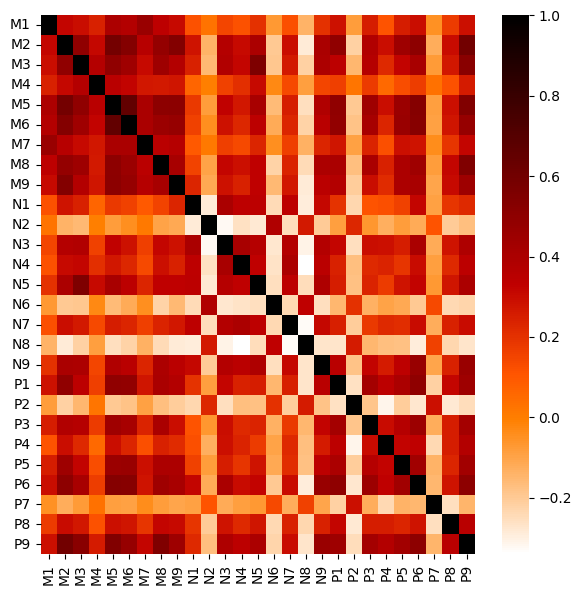

In [10]:
# Correlation Heatmap 
plt.figure(figsize = (7,7))
sns.heatmap(data = dark_triad_df.corr(), cmap = 'gist_heat_r');
plt.show()

## Prediction Time

The idea would be to predict the average score a person receives for a given triad's questions based on the other two
triad question scores.

In [11]:
# Separating out the questions by triad class
narcis_questions = [f'N{int(i)}' for i in np.linspace(1, 9, 9)]
psych_questions = [f'P{int(i)}' for i in np.linspace(1, 9, 9)]
mach_questions = [f'M{int(i)}' for i in np.linspace(1, 9, 9)]

In [12]:
# Making 3 dataframes; each is missing either narcissism, psychopathy, or machievellianism questions

# Not narcissism questions dataframe
not_narcis_df = pd.DataFrame()

for i in dark_triad_df.columns:
    if i not in narcis_questions:
        not_narcis_df[f'{i}'] = dark_triad_df[i]
        
# Not psychopathy questions dataframe
not_psych_df = pd.DataFrame()

for i in dark_triad_df.columns:
    if i not in psych_questions:
        not_psych_df[f'{i}'] = dark_triad_df[i]
        
# Not Machievellianism questions dataframe
not_mach_df = pd.DataFrame()

for i in dark_triad_df.columns:
    if i not in mach_questions:
        not_mach_df[f'{i}'] = dark_triad_df[i]

In [23]:
# Computing average scores by question type per row.

# Lists of average scores
narcis_df = dark_triad_df[['N1', 'N2', 'N3', 'N4', 'N5', 'N6', 'N7', 'N8', 'N9']]
mach_df = dark_triad_df[['M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9']]
psych_df = dark_triad_df[['P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9']]

# Dataframe of the average score by category per person
triad_class_scores = pd.DataFrame({
    'narcissism_score': narcis_df.mean(axis = 1).round(3),
    'psychopathy_score': psych_df.mean(axis = 1).round(3),
    'machievellianism_score': mach_df.mean(axis = 1).round(3)
})

#The columns will become targets during model-making.
triad_class_scores.head(3), triad_class_scores.shape

(   narcissism_score  psychopathy_score  machievellianism_score
 0             3.111              3.556                   3.889
 1             2.889              2.556                   2.222
 2             2.889              2.444                   3.222,
 (18192, 3))

### Predicting Average narcissism score


In [14]:
# STEP 1: Setting up the features and target
X = not_narcis_df
y = triad_class_scores['narcissism_score']

# STEP 2: Creating training and testing sets
# Note: I will always use random_state 137 for consistency in testing.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 137)

In [15]:
# STEP 3: Instantiating/fitting a linear regression model (no tuning)
linreg_model = LinearRegression()
linreg_model.fit(X_train, y_train)

LinearRegression()

In [16]:
# STEP 4: Scoring the linear regression model
linreg_model.score(X_test, y_test)  # approximately 29.09% 

0.2945441006231543

In [17]:
# STEP 5: Instantiating/fitting a knn regression model (no tuning)
knn_model = KNeighborsRegressor()
knn_model.fit(X_train, y_train)

KNeighborsRegressor()

In [18]:
# STEP 6: Scoring the KNN regression model
knn_model.score(X_test, y_test) # approx. 18.75%

0.18212571741193717

In [19]:
# Trying random forest, Bagging, GradientBoosting, XGB (all untuned)

# Random Forest
rf_model = RandomForestRegressor()
rf_model.fit(X_train, y_train)
rf_model.score(X_test, y_test) # approx. 27.5%

# Bagging
bag_model = BaggingRegressor()
bag_model.fit(X_train, y_train)
bag_model.score(X_test, y_test) # approx. 19.3%

# GradientBoosting
gb_model = GradientBoostingRegressor()
gb_model.fit(X_train, y_train)
gb_model.score(X_test, y_test) # approx. 30.16%

# XGB
xgb_model = XGBRegressor()
xgb_model.fit(X_train, y_train) # approx. 22%

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [20]:
# Scores
(linreg_model.score(X_test, y_test),
knn_model.score(X_test, y_test),
rf_model.score(X_test, y_test), 
bag_model.score(X_test, y_test),
gb_model.score(X_test, y_test),
xgb_model.score(X_test, y_test))

(0.2945441006231543,
 0.18212571741193717,
 0.2733571881826943,
 0.20158392683213655,
 0.30543409623634077,
 0.23313113997667434)

It seems unlikely that I have enough data to make a regression model that has an *R-Squared* model 
higher than approximately 31%. So, as an initial analysis, I will group the target scores into
classes in the following manners to make a classification model:

**Version 1:** Rounded classes [1-2, 2-3, 3-4, 4-5]

**Version 2:** If *version 1* is not accurate enough (ideally +75%), I will reduce the target
to two classes: **high** (+4) and **low** (<4)

**WARNING: LOOK AT RECALL, PRECISION, F1-SCORE for classification models**

In [31]:
# VERSION 1 (will include Logistic and KNN classifiers):
y_rounded = triad_class_scores['narcissism_score']

# Classifying each element as one of 4 classes
y_rounded = y_rounded.apply(round)

# Resplitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y_rounded, test_size = 0.3, random_state = 137)

In [34]:
# Logistic Classifier

# Instantiating the model
logreg_model = LogisticRegression(max_iter = 10000)

# Fitting the model
logreg_model.fit(X_train, y_train)

LogisticRegression(max_iter=10000)

In [35]:
# Scoring the model
logreg_model.score(X_test, y_test)  # much better (approx. 74.6%)

0.7462440454378894

In [36]:
# KNN Classifier

# Instantiating the model
knn_classifier_model = KNeighborsClassifier()

# Fitting the model
knn_classifier_model.fit(X_train, y_train)

KNeighborsClassifier()

In [37]:
# Scoring the model
knn_classifier_model.score(X_test, y_test)  # not quite as good (approx.  71.5%)

0.7150971051667278

In [ ]:
# TRYING A DEEP LEARNING CLASSIFICATION MODEL